# Imports

In [1]:
import math
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import tiktoken
from transformers import GPT2Tokenizer
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, DatasetDict
from torchsummaryX import summary
import wandb
from dataclasses import dataclass
from tqdm import tqdm
import re
from multiprocessing import cpu_count
import random
import gc
import pickle

In [2]:
# set seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
cudnn.deterministic = True
cudnn.benchmark = False
random.seed(42)

# Load Data

In [3]:
datasets_train = load_dataset("Shannnh/hw5-changed", split = 'train')
datasets_val = load_dataset("Shannnh/hw5-changed", split = 'validation')
datasets_test = load_dataset("Shannnh/hw5-changed", split = 'test_ds')

In [4]:
print(datasets_train[0].keys())
print(len(datasets_train))
print(len(datasets_val))
print(len(datasets_test))

dict_keys(['Classifier', 'Prompt', 'Messages', 'PromptId'])
392632
27664
15434


In [5]:
datasets_train = datasets_train.shuffle(seed=42).select(range(100))
datasets_val = datasets_val.shuffle(seed=42).select(range(10))

In [6]:
datasets_train.unique('Classifier')

['Question&Answer', 'Summarization', 'NamedEntity']

# Hyperparameters

In [7]:
@dataclass
class IDeaLGPTConfig:

    # General
    batch_size: int = 8 # 16
    gradient_accumulation_steps: int = 4
    num_iters: int = 10000
    eval_iters: int = 3
    eval_interval: int = 1000
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    # device: str = 'cpu'

    # Model
    sequence_length: int = 256
    vocab_size: int = 50257 # gpt2 vocab
    num_blocks: int = 8
    num_heads: int = 8
    embed_dim: int = 512
    dropout: float = 0.1
    bias: bool = False

    # Data
    num_workers: int = 8
    train_test_split: float = 0.8
    SUBSET_PERCENTAGE: float =0.01 # % of OWT to train on, between 0 and 1

    # LR scheduler
    lr: float = 2e-3
    lr_decay: bool = True
    warmup_iters: int = 1000
    min_lr: float = 6e-6

    # optimizer
    weight_decay: float = 1e-1
    grad_clip: float = 1.0


config = IDeaLGPTConfig()
device = config.device
config

IDeaLGPTConfig(batch_size=8, gradient_accumulation_steps=4, num_iters=10000, eval_iters=3, eval_interval=1000, device='cuda', sequence_length=256, vocab_size=50257, num_blocks=8, num_heads=8, embed_dim=512, dropout=0.1, bias=False, num_workers=8, train_test_split=0.8, SUBSET_PERCENTAGE=0.01, lr=0.002, lr_decay=True, warmup_iters=1000, min_lr=6e-06, weight_decay=0.1, grad_clip=1.0)

In [8]:
print(f'Effective batch size = {config.batch_size * config.gradient_accumulation_steps}')

Effective batch size = 32


# Loading Data and Preprocessing

In [9]:
# hf_dataset = load_dataset("Skylion007/openwebtext", split='train') # only has one split - train
# hf_dataset = hf_dataset.with_format("torch")
# hf_dataset

In [10]:
# # data = dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * SUBSET_PERCENTAGE)))
# # hf_dataset = hf_dataset.select(range(int(len(hf_dataset) * config.SUBSET_PERCENTAGE)))
# hf_dataset = hf_dataset.train_test_split(train_size=config.train_test_split)
# hf_dataset

In [11]:
# train_hf_dataset, val_hf_dataset = hf_dataset['train'], hf_dataset['test']

## Tokenizer - OpenAI tiktoken (changed to GPT2Tokenizer)

In [12]:
#tokenizer = tiktoken.get_encoding("cl100k_base") # gpt4 tokenizer - NOTE: need to change vocab_size in config if used
#tokenizer = tiktoken.encoding_for_model('gpt-2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.encode('hello world')


[31373, 995]

In [13]:
tokenizer.model_max_length = config.sequence_length

In [14]:
tokenizer.pad_token_id

In [15]:
vocab_size = tokenizer.vocab_size #same as tiktoken
vocab_size

50257

In [16]:
# set pad_token_id equal to the eos_token_id if not set
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

In [17]:
DEFAULT_CHAT_TEMPLATE = "{% for message in messages %}\n{% if message['role'] == 'user' %}\n{{ '<|user|>\n' + ' '.join(message['content'].split()[:150]) + eos_token }}\n{% elif message['role'] == 'system' %}\n{{ '<|system|>\n' + message['content'] + eos_token }}\n{% elif message['role'] == 'assistant' %}\n{{ '<|assistant|>\n'  + message['content'] + eos_token }}\n{% endif %}\n{% if loop.last and add_generation_prompt %}\n{{ '<|assistant|>' }}\n{% endif %}\n{% endfor %}"
tokenizer.chat_template = DEFAULT_CHAT_TEMPLATE

In [18]:
def apply_chat_template(example, tokenizer):
    messages = example["Messages"]
    #
    example["text"] = tokenizer.apply_chat_template(messages, tokenize=False, max_length=config.sequence_length, truncation=True)
    example["tokens"] = tokenizer.apply_chat_template(messages, tokenize=True, max_length=config.sequence_length, truncation=True)
    return example

column_names = list(datasets_train.features)
datasets_train = datasets_train.map(apply_chat_template,
                                num_proc=cpu_count(),
                                fn_kwargs={"tokenizer": tokenizer},
                                remove_columns=column_names,
                                desc="Applying chat template")
datasets_val = datasets_val.map(apply_chat_template,
                                num_proc=cpu_count(),
                                fn_kwargs={"tokenizer": tokenizer},
                                remove_columns=column_names,
                                desc="Applying chat template")
datasets_test = datasets_test.map(apply_chat_template,
                                num_proc=cpu_count(),
                                fn_kwargs={"tokenizer": tokenizer},
                                remove_columns=column_names,
                                desc="Applying chat template")


Applying chat template (num_proc=40):   0%|          | 0/100 [00:00<?, ? examples/s]

num_proc must be <= 10. Reducing num_proc to 10 for dataset of size 10.


Applying chat template (num_proc=10):   0%|          | 0/10 [00:00<?, ? examples/s]

Applying chat template (num_proc=40):   0%|          | 0/15434 [00:00<?, ? examples/s]

In [19]:
# what's in datasets now
# datasets_train : [{'text':'abcd','tokens':[1,2,3]},{'text':'bcd','tokens':[2,3]},...]
for index in random.sample(range(len(datasets_val)), 2):
    print(f"Sample {index} of the processed training set:\n\n{datasets_val[index]['text']}")
    print(f"token: {datasets_val[index]['tokens']}")
    print(f"sample length: {len(datasets_val[index]['text'])}") 
    print(f"token length:{len(datasets_val[index]['tokens'])}")

Sample 1 of the processed training set:

<|system|>
<|endoftext|>
<|user|>
Summarize the following CNN article: A New South Wales company has been forced to settle a tab of more than $10,000 with the ACCC, after it advertised '100 per cent Aussie' beer that was actually made in China. The Independent Liquor Group was hit with an infringement notice by the Australian Competition and Consumer Commission, and had to pay the fine of $10,200 after its green and gold clad beer was falsely advertised. Independent Liquor Group was fined for advertising this Chinese brewed beer as 'Aussie beer' 'Aussie Beer' labelling from March 2014 to August 2014 featured a map of Australia with '100 per cent owned' inside it, and the statement 'Australia's finest malt'. However, contrary to what its packaging suggested, the beer is made in China. The ACCC dished out the penalty in accordance with the Australian Consumer Law. 'Country of origin representations, particularly those designed to grab the<|endofte

In [20]:
total_token_length = 0
sample_count = len(datasets_train)

# Calculate total token length across all samples
for data in tqdm(datasets_train):
    encoded_length = len(tokenizer.encode(data['text']))
    total_token_length += encoded_length

# Compute the average token length
average_token_length = total_token_length / sample_count

print(f"Average token length: {average_token_length}")

100%|██████████| 100/100 [00:00<00:00, 348.86it/s]

Average token length: 255.09


In [21]:
torch.cuda.empty_cache()
gc.collect()

31

In [22]:
# save dataset

def save_dataset(dataset, filename):
    with open(filename, 'wb') as f:
        pickle.dump(dataset, f)
save_dataset(datasets_train, 'data/finetune/train.bin')
save_dataset(datasets_val, 'data/finetune/val.bin')
save_dataset(datasets_test, 'data/finetune/test.bin')

## Pytorch Dataset

For long texts, the current approach randomly selects segments of text that are equal to config.sequence_length. However, methods such as sliding windows could also be explored.

In [23]:
class TrainDataset(Dataset):
    def __init__(self, root_dir, split):
        """
        Args:
            root_dir (str): Dataset root directory containing the data files.
        """
        file_path = os.path.join(root_dir, "train.bin") if split == 'train' else os.path.join(root_dir, "val.bin")
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        tokens = sample['tokens']
        # if the number of tokens is more than the sequence_length, randomly choose a segment
        # if len(tokens) > config.sequence_length + 1:
        #     num_possible_starts = len(tokens) - config.sequence_length
        #     start = random.randint(0, num_possible_starts - 1)
        #     segment = tokens[start:start + self.sequence_length + 1]
        # else:
        #     segment = tokens

        if len(tokens) < config.sequence_length + 1:
            padded_tokens = np.pad(tokens, (0, config.sequence_length + 1 - len(tokens)), 'constant', constant_values=tokenizer.pad_token_id)
        else:
            padded_tokens = tokens[:config.sequence_length + 1]

        xb = torch.tensor(padded_tokens[:-1], dtype=torch.int64)
        yb = torch.tensor(padded_tokens[1:], dtype=torch.int64)
        return xb, yb


In [24]:
# class TestDataset(Dataset):
#     def __init__(self, root_dir):
#         """
#         Args:
#             root_dir (str): Dataset root directory containing the data files.
#         """
#         file_path = os.path.join(root_dir, "test.bin")
#         with open(file_path, 'rb') as f:
#             data = pickle.load(f)
#         self.data = data

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         sample = self.data[idx]
#         tokens = sample['tokens']
#         # if len(tokens) > config.sequence_length + 1:
#         #     num_possible_starts = len(tokens) - config.sequence_length
#         #     start = random.randint(0, num_possible_starts - 1)
#         #     segment = tokens[start:start + config.sequence_length + 1]
#         # else:
#         #     segment = tokens
#         if len(tokens) < config.sequence_length + 1:
#             padded_tokens = np.pad(tokens, (0, config.sequence_length + 1 - len(tokens)), 'constant', constant_values=tokenizer.pad_token_id)
#         else:
#             padded_tokens = tokens[:config.sequence_length + 1]

#         xb = torch.tensor(padded_tokens[:-1], dtype=torch.int64)
#         return xb


## Dataloader

In [25]:
# train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=1)
# val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)

In [ ]:
# for x, y in train_loader:
#     print(x.shape, y.shape)
#     break

In [ ]:
'''
# poor man's dataloader
# but actual motivation is - im too lazy to write and deal with pad tokens in above method to read data
# since there are documents which are less than sequence length and they mess up the batch
# this method is cleaner, i get to learn something new (np.memmap!) and it's fun!

data_dir = os.path.join('data', 'owt')

def get_batch(split):
    file_path = os.path.join(data_dir, 'val' if split == 'val.bin' else 'train.bin')
    # memmap allows to read huge .bin files without loading entire thing. magic?
    data = np.memmap(file_path, mode='r', dtype=np.uint16) # fp16?
    idx = torch.randint(len(data) - config.sequence_length, (config.batch_size, ))
    xb = torch.stack([torch.from_numpy(data[i:i+config.sequence_length].astype(np.int64)) for i in idx], dim=0)
    yb = torch.stack([torch.from_numpy(data[i+1:i+config.sequence_length+1].astype(np.int64)) for i in idx], dim=0)
    if device == 'cuda':
        # pin_memory is an optimization to reserve some space in cpu mem which is used for moving to gpu
        # reduces overhead -> increases perf
        # non_blocking = True is async data transfer
        xb, yb = xb.pin_memory().to(device, non_blocking=True), yb.pin_memory().to(device, non_blocking=True)
    return xb, yb
'''

In [26]:

DATA_DIR        = 'data/finetune'

train_dataset   = TrainDataset(
    root_dir    = DATA_DIR,
    split   = "train"
)

val_dataset     = TrainDataset(
    root_dir    = DATA_DIR,
    split   = "val"
)

# test_dataset    = TestDataset(
#     root_dir    = DATA_DIR
# )
gc.collect()


0

In [27]:
xb, yb = train_dataset[0]
xb.shape, yb.shape

(torch.Size([256]), torch.Size([256]))

In [28]:
train_loader    = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config.batch_size,
    shuffle     = True,
    num_workers = 2,
    pin_memory  = True
)

val_loader      = torch.utils.data.DataLoader(
    dataset     = val_dataset,
    batch_size  = config.batch_size,
    shuffle     = False,
    num_workers = 1,
    pin_memory  = True
)

# test_loader     = torch.utils.data.DataLoader(
#     dataset     = test_dataset,
#     batch_size  = config.batch_size,
#     shuffle     = False,
#     num_workers = 1,
#     pin_memory  = True
# )

print("Batch Size           : ", config.batch_size)
print("Train Batches        : ", train_loader.__len__())
print("Val Batches          : ", val_loader.__len__())
# print("Test Batches         : ", test_loader.__len__())


Batch Size           :  8
Train Batches        :  13
Val Batches          :  2


In [29]:
''' Sanity Check '''

print("Checking the Shapes of the Data --\n")

for batch in train_loader:
    xb, yb = batch

    print(f"xb shape:\t\t{xb.shape}")
    print(f"yb shape:\t\t{yb.shape}\n")



    break

Checking the Shapes of the Data --

xb shape:		torch.Size([8, 256])
yb shape:		torch.Size([8, 256])



In [ ]:
# I tried it, but failed.QAQ. It seems that using np.memmap requires synchronously recording the length of each data entry, which makes padding inconvenient.
'''
data_dir = '/content/hw5/'
def get_batch(split):
    file_path = os.path.join(data_dir, 'val.bin' if split == 'val' else 'train.bin')


    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    xb = torch.empty((config.batch_size, config.sequence_length), dtype=torch.int64)
    yb = torch.empty((config.batch_size, config.sequence_length), dtype=torch.int64)

    for b in range(config.batch_size):
        tokens = data[b]['tokens']
        if len(tokens) < config.sequence_length:
            padded_tokens = np.pad(tokens, (0, config.sequence_length - len(tokens)), 'constant', constant_values=tokenizer.pad_token_id)
        else:
            padded_tokens = tokens[:config.sequence_length]


        xb[b] = torch.tensor(padded_tokens[:-1], dtype=torch.int64)
        yb[b] = torch.tensor(padded_tokens[1:], dtype=torch.int64)

    if device == 'cuda':
        xb, yb = xb.pin_memory().to(device, non_blocking=True), yb.pin_memory().to(device, non_blocking=True)

    return xb, yb
'''

# Model

In [30]:
class Head(nn.Module):
    # def __init__(self, embed_dim, head_size, sequence_length, dropout):
    def __init__(self, config, interim_head_size):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.interim_head_size = interim_head_size # say embed_dim = 32 -> broken into say 4 heads, so this will be 8, to be concated back to 32
        self.key = nn.Linear(config.embed_dim, interim_head_size, bias=config.bias)
        self.query = nn.Linear(config.embed_dim, interim_head_size, bias=config.bias)
        self.value = nn.Linear(config.embed_dim, interim_head_size, bias=config.bias)
        self.register_buffer('tril', torch.tril(torch.ones((config.sequence_length, config.sequence_length))))

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (b,t,c) -> (b,t,h)
        q = self.query(x) # (b,t,c) -> (b,t,h)
        v = self.value(x) # (b,t,c) -> (b,t,h)
        wei = k @ q.transpose(-2, -1) * self.embed_dim**(-0.5) # (b,t,h) @ (b,h,t) -> (b,t,t)

        wei = wei.masked_fill((self.tril[:T, :T] == 0.), -torch.inf) # type: ignore
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        xbow = wei @ v # (b,t,t) @ (b,t,h) -> (b,t,h)
        return xbow

class MultiHeadAttention(nn.Module):
    # def __init__(self, num_heads, embed_dim, head_size, sequence_length, dropout):
    def __init__(self, config, interim_head_size):
        super().__init__()
        self.head_list = nn.ModuleList([Head(config, interim_head_size) for _ in range(config.num_heads)])
        self.proj = nn.Linear(config.embed_dim, config.embed_dim)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.head_list], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(config.embed_dim, 4*config.embed_dim),
            nn.GELU(),
            nn.Linear(4*config.embed_dim, config.embed_dim),
            nn.Dropout(config.dropout)
        )

    def forward(self, x):
        return self.layers(x)

class Block(nn.Module):
    # def __init__(self, num_heads, embed_dim, sequence_length, dropout):
    def __init__(self, config):
        super().__init__()
        self.interim_head_size = config.embed_dim // config.num_heads
        self.sa = MultiHeadAttention(config, self.interim_head_size)
        self.ff = FeedForward(config)
        self.ln1 = nn.LayerNorm(config.embed_dim)
        self.ln2 = nn.LayerNorm(config.embed_dim)

    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # communication
        x = x + self.ff(self.ln2(x)) # computation
        return x


class Transformer(torch.nn.Module):
    # def __init__(self, embed_dim, vocab_size, sequence_length, num_heads, num_blocks, dropout):
    def __init__(self, config):
        super().__init__()
        self.sequence_length = config.sequence_length
        self.token_embeddings = torch.nn.Embedding(config.vocab_size, config.embed_dim)
        self.position_embeddings = nn.Embedding(config.sequence_length, config.embed_dim)
        self.block_list = nn.Sequential(*[Block(config)
                                          for _ in range(config.num_blocks)])
        self.final_ln = nn.LayerNorm(config.embed_dim)
        self.lm_head = nn.Linear(config.embed_dim, config.vocab_size)

    def forward(self, ixs, targets=None):
        # ixs: (b,t)
        # targets: (b,t)
        B, T = ixs.shape
        x = self.token_embeddings(ixs) # (b,t,c=embed_dim)
        pos_embeds = self.position_embeddings(torch.arange(T, device=device)) # (t,c=embed_dim)
        x += pos_embeds
        x = self.block_list(x)
        x = self.final_ln(x)
        logits = self.lm_head(x) # (b,t,c=vocab_size)
        if targets is None:
            loss = None
        else:
            mask = (ixs != tokenizer.pad_token_id)  # (b,t), True where not a pad token
            logits = logits.permute(0, 2, 1)  # (b,c,t)
    
            # Use the mask to filter out loss on padding positions
            # logits are now (b, c, t), targets are (b, t), mask is (b, t)
            # Utilizing .masked_fill to turn pad positions to a very large negative value to ignore them in softmax
            loss = F.cross_entropy(logits, targets, reduction='none')  # (b, t) get loss per token
            loss = (loss * mask).sum() / mask.sum()  # average loss only over non-pad tokens
        return logits, loss

    def generate(self, ixs, max_len):
        """
        ixs: (b,t) - input sequence to start generating from
        max_len: int - maximum length of the generated sequence
        """
        b, t = ixs.shape
        for _ in range(max_len):
            # generation (b, ) next tokens in parallel
            ixs_cond = ixs[:, -self.sequence_length:] # consider only the last sequence_length tokens
            logits, loss = self.forward(ixs_cond) # logits=(b,t,c), loss is ignored
            # get juse the final timestep
            last_logits = logits[:, -1, :] # (b,c)
            # normalize
            last_probs = F.softmax(last_logits, dim=-1) # across c
            next_tokens = torch.multinomial(last_probs, 1) # (b,c) -> (b)
            ixs = torch.cat((ixs, next_tokens), dim=1) # across t so (b,t) -> (b, t+1)
        return ixs


# Training

In [31]:
# model = Transformer(embed_dim, vocab_size, sequence_length, num_heads, num_blocks, dropout).to(device)
model = Transformer(config).to(device)

In [32]:
summary(model, xb.to(device), yb.to(device))

                                                 Kernel Shape  \
Layer                                                           
0_token_embeddings                               [512, 50257]   
1_position_embeddings                              [512, 256]   
2_block_list.0.LayerNorm_ln1                            [512]   
3_block_list.0.sa.head_list.0.Linear_key            [512, 64]   
4_block_list.0.sa.head_list.0.Linear_query          [512, 64]   
5_block_list.0.sa.head_list.0.Linear_value          [512, 64]   
6_block_list.0.sa.head_list.0.Dropout_dropout               -   
7_block_list.0.sa.head_list.1.Linear_key            [512, 64]   
8_block_list.0.sa.head_list.1.Linear_query          [512, 64]   
9_block_list.0.sa.head_list.1.Linear_value          [512, 64]   
10_block_list.0.sa.head_list.1.Dropout_dropout              -   
11_block_list.0.sa.head_list.2.Linear_key           [512, 64]   
12_block_list.0.sa.head_list.2.Linear_query         [512, 64]   
13_block_list.0.sa.head_l

/home/ssg2/miniconda3/envs/idl/lib/python3.8/site-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_token_embeddings,"[512, 50257]","[8, 256, 512]",25731584.0,25731584.0
1_position_embeddings,"[512, 256]","[256, 512]",131072.0,131072.0
2_block_list.0.LayerNorm_ln1,[512],"[8, 256, 512]",1024.0,512.0
3_block_list.0.sa.head_list.0.Linear_key,"[512, 64]","[8, 256, 64]",32768.0,32768.0
4_block_list.0.sa.head_list.0.Linear_query,"[512, 64]","[8, 256, 64]",32768.0,32768.0
...,...,...,...,...
319_block_list.7.ff.layers.GELU_1,-,"[8, 256, 2048]",NaN,NaN
320_block_list.7.ff.layers.Linear_2,"[2048, 512]","[8, 256, 512]",1049088.0,1048576.0
321_block_list.7.ff.layers.Dropout_3,-,"[8, 256, 512]",NaN,NaN


In [33]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
scaler = torch.cuda.amp.GradScaler(enabled=True)


# for generation
start_ix = torch.zeros((1,1), dtype=torch.long, device=device) # (newline character in a single batch)

In [34]:
# poor man's lr scheduler. why? because cosine with warmup isn't readily available on torch (it's warm RESTARTS)
# but idc about restarting eh?
def get_lr(it):
    "get lr at a specific iteration"
    max_lr = config.lr
    min_lr = config.min_lr
    warmup_iters = config.warmup_iters
    max_lr_decay_iters = config.num_iters # can also be made into another param
    if it <= warmup_iters:
        return max_lr * (it / warmup_iters)

    if it > max_lr_decay_iters:
        # decaying only up to a certain point, interesting
        return min_lr
    ratio = (it - warmup_iters) / (max_lr_decay_iters - warmup_iters) # how much % of decay cycle is done?
    coeff = 0.5 * (1 + math.cos(math.pi * ratio)) # [0,1]
    return min_lr + coeff * (max_lr - min_lr) # beautiful

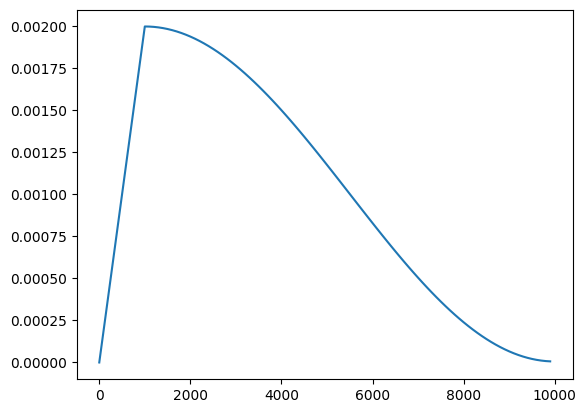

In [35]:
def test_lr():
    import random
    import matplotlib.pyplot as plt
    x = [i for i in range(0,10000,100)]
    y = [get_lr(i) for i in x]
    plt.plot(x, y)
    plt.show()

test_lr()


In [ ]:
'''
@torch.no_grad()
def estimate_losses(config):
    model.eval()
    losses = {'train': -1., 'val': -1.}
    for split in ['train', 'val']:
        loss = 0
        for _ in range(config.eval_iters):
            # xb, yb = next(iter(val_loader))
            # xb, yb = xb.to(device), yb.to(device)
            xb, yb = get_batch('val')
            loss += model(xb, yb)[1].item()
        loss /= config.eval_iters
        if split == 'train':
            losses['train'] = loss
        else:
            losses['val'] = loss
    model.train()
    return losses
    '''

In [36]:
@torch.no_grad()
def estimate_losses(config, train_loader, val_loader):
    model.eval()
    losses = {'train': -1., 'val': -1.}
    train_loss = 0
    train_iters = min(config.eval_iters, len(train_loader))
    for i, (xb, yb) in enumerate(train_loader):
        if i >= train_iters:
            break
        xb, yb = xb.to(device), yb.to(device)
        _, loss = model(xb, yb)
        train_loss += loss.item()
    losses['train'] = train_loss / train_iters

    # Evaluate validation loss (considering only config.eval_iters iterations)
    val_loss = 0
    val_iters = min(config.eval_iters, len(val_loader))
    for i, (xb, yb) in enumerate(val_loader):
        if i >= val_iters:
            break
        xb, yb = xb.to(device), yb.to(device)
        _, loss = model(xb, yb)
        val_loss += loss.item()
    losses['val'] = val_loss / val_iters

    model.train()
    return losses

In [44]:
#@title Load Pretrained
CKPT_PATH = 'exps/pretrain_v2/best_model.pth'
ckpt = torch.load(CKPT_PATH)
model.load_state_dict(ckpt)

<All keys matched successfully>

## WandB

In [42]:
wandb.login(key="")
run = wandb.init(
        name    = 'pretrain_v1', ## Wandb creates random run names if you skip this field
        reinit = True, ### Allows reinitalizing runs when you re-run this cell
        # entity = 'thunderbuddies',
        # run_id = ### Insert specific run id here if you want to resume a previous run
        # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
        project = "ideal_gpt", ### Project should be created in your wandb account
        config = config, ### Wandb Config for your run,
        mode='disabled'

    )

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [43]:
start_ix.shape

torch.Size([1, 1])

In [45]:
cur_iter = 0
best_val = 1e9
best_path = 'tmp_best_model.pth'
running_loss = 0.0
loss_counter=0
pbar = tqdm(total=config.num_iters, dynamic_ncols=True, leave=False, position=0, desc="Train")

Train:   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
'''
while cur_iter <= config.num_iters:
    optimizer.zero_grad(set_to_none = True) # https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html
    # poor man's lr scheduler
    cur_lr = get_lr(cur_iter) if config.lr_decay else config.lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = cur_lr

    # xb, yb = next(iter(train_loader))
    for micro_step in range(config.gradient_accumulation_steps):
        xb, yb = get_batch('train')
        # xb, yb = xb.to(device), yb.to(device)
        with torch.cuda.amp.autocast():
            logits, loss = model(xb, yb)

        running_loss += loss.item()
        train_loss = running_loss / (loss_counter + 1)
        loss_counter += 1

        scaler.scale(loss).backward()

    if config.grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
    scaler.step(optimizer)
    scaler.update()

    # val every eval_intervals
    if cur_iter % config.eval_interval == 0:
        losses = estimate_losses(config)
        val_loss = losses['val']
        train_loss = losses['train']
        print(f'Val @ Epoch {cur_iter}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}')
        wandb.log({
            'val_loss': val_loss,
            'iter': cur_iter,
            'lr': optimizer.param_groups[0]['lr']
        })
        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), best_path)
            print(f'Saved best model to {best_path}')
        print('Sample Generation')
        print(tokenizer.decode(model.generate(start_ix, 100)[0].tolist()))

    # train logs
    wandb.log({
        'train_loss': train_loss,
        'iter': cur_iter,
        'lr': cur_lr
    })
    pbar.set_postfix(
            loss = "{:.04f}".format(train_loss),
            lr = cur_lr
        )
    pbar.update()


    cur_iter += 1
    '''

In [49]:
torch.cuda.empty_cache()
gc.collect()


NUM_EPOCHS=5
cur_iter=0

while cur_iter <= NUM_EPOCHS:
    optimizer.zero_grad(set_to_none=True)

    cur_lr = get_lr(cur_iter) if config.lr_decay else config.lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = cur_lr

    # Iterate over batches from the DataLoader
    steps = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        with torch.cuda.amp.autocast():
            logits, loss = model(xb, yb)
        running_loss += loss.item()
        train_loss = running_loss / (loss_counter + 1)
        loss_counter += 1

        scaler.scale(loss).backward()

        steps += 1
        if steps % config.gradient_accumulation_steps == 0:
            if config.grad_clip != 0.0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        del xb, yb, logits, loss
        torch.cuda.empty_cache()


    if cur_iter % config.eval_interval == 0:
        losses = estimate_losses(config, train_loader, val_loader)  # Now we pass val_loader to estimate_losses
        val_loss = losses['val']
        train_loss = losses['train']
        print(f'Val @ Epoch {cur_iter}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}')
        wandb.log({
            'val_loss': val_loss,
            'iter': cur_iter,
            'lr': optimizer.param_groups[0]['lr']
        })
        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), best_path)
            print(f'Saved best model to {best_path}')
        print('Sample Generation')
        print(tokenizer.decode(model.generate(start_ix, 100)[0].tolist()))

    # Log training metrics for current iteration
    wandb.log({
        'train_loss': train_loss,
        'iter': cur_iter,
        'lr': cur_lr
    })
    pbar.set_postfix(loss="{:.04f}".format(train_loss), lr=cur_lr)
    pbar.update()

    cur_iter += 1  # Increment iteration count

Val @ Epoch 0: Train Loss=2.2386, Val Loss=2.9403
Saved best model to tmp_best_model.pth
Sample Generation


Train:   0%|          | 23/10000 [02:25<60:48:30, 21.94s/it, loss=2.2386, lr=0]    

! We officially launched MMD here! Get our daily newsletter HERE!<|endoftext|>New culture

Narc levitation has evolved from an island which practiced practicality. Now it has taken the form of a perfectly normal, beautiful, urban startup called Misanthropy, or MakuinOBY. MakuinOBY is not simply a sustainable hobby one can take to make the ‘thing’ off, it is also one that decides what goes making use of them all at enlisted,


Train:   0%|          | 28/10000 [02:40<17:14:53,  6.23s/it, loss=3.1096, lr=1e-5]

In [ ]:
print(tokenizer.decode(model.generate(start_ix, 100)[0].tolist()))

In [ ]:
def prompt(p, max_len=100):
    if not p:
        print('Enter non-empty string!')
        return

    tokens = torch.tensor(tokenizer.encode_ordinary(p))
    tokens = tokens.unsqueeze(0) # add batch dimension
    tokens = tokens.to(device)
    return tokenizer.decode(model.generate(tokens, max_len)[0].tolist())

In [ ]:
prompt('Hello world, my name is' , 1)